# Motivation

Volatility plays a central role in investment decision-making, risk management, and economic forecasting. The VIX, often called the "fear index," captures market expectations of near-term volatility and used as a proxy for market sentiment.

Volatility is influenced by a complex mix of factors: economic conditions, investor sentiment, and global events. These factors don't always have a direct linear relationship.  These factors interact in nuanced ways that traditional models may fail to capture.

Rather than assuming labels or predefined regimes, we leverage unsupervised techniques Principal Component Analysis (PCA) and Clustering to:

- Discover hidden structure in the market behavior
- Group similar volatility conditions into regimes (e.g., calm, stress, panic)
- Visualize market transitions across time without relying on expert-annotated data
- Detect anomalies in historical periods where volatility behaved unusually

We apply PCA to reduce dimensionality, preserving the most important variation in macroeconomic and sentiment factors while eliminating noise. Then, we use clustering to categorize days into meaningful volatility regimes without any prior labeling.

This unsupervised approach allows us to detect emerging trends, detect outliers.

This approach could be used by:
- Traders to identify market conditions similar to historical crises or recoveries
- Portfolio managers to adjust risk exposure based on regime shifts
- Economists to contextualize unemployment and sentiment with market volatility

By applying unsupervised learning, we toward exploratory, interpretable, and proactive insights in financial data.

# Data Sources
This project brings together multiple real-world datasets that reflect different dimensions of market behavior:

### 1. **VIX Historical Data**
- **Source**: [Yahoo Finance](https://finance.yahoo.com/quote/%5EVIX/history)
- **Description**: Daily open, high, low, close (OHLC), and volume data for the CBOE Volatility Index (VIX), capturing investor expectations of 30-day market volatility.
- **Use**: We use the `Close` price as the primary indicator of market volatility and engineer features such as `VIX Range` (`High - Low`) and `Log Close Change` (log returns) to capture intraday and interday volatility dynamics.

### 2. **News Sentiment Index**
- **Source**: [Federal Reserve Bank of San Francisco – Daily News Sentiment Index](https://www.frbsf.org/research-and-insights/data-and-indicators/daily-news-sentiment-index/)
- **Description**: Daily sentiment scores derived from news coverage, where lower values represent more negative sentiment. This acts as a proxy for market psychology and investor mood.
- **Use**: We compute the daily `Log Sentiment Change` to capture shifts in sentiment momentum that may precede or coincide with changes in market volatility.

### 3. **Unemployment Rate**
- **Source**: [Federal Reserve Economic Data (FRED) – UNRATE Series](https://fred.stlouisfed.org/series/UNRATE)
- **Description**: Monthly U.S. unemployment rate, used as a macroeconomic indicator of economic stress and longer-term market expectations.
- **Use**: Since it is reported monthly, we forward-fill the unemployment rate so it aligns with the daily frequency of the VIX and sentiment data.


## **Data Integration Strategy**

To align and combine these datasets:
1. We parsed and loaded each dataset into a pandas DataFrame, standardizing the `Date` column across all sources.
2. We merged the datasets on the `Date` field, using an inner join between the VIX and sentiment data (both daily), and a left join with the unemployment data (forward-filled to daily granularity).
3. The merged dataset was cleaned by:
   - Dropping irrelevant or redundant columns (e.g., `Open`, `Volume`, `High`, `Low`)
   - Handling missing values by dropping rows introduced from differencing/logging
   - Engineering features such as:
     - `Log_Close_Change`: Daily log returns of VIX
     - `Log_Sentiment_Change`: First difference of sentiment
     - `VIX_Range`: High–Low intraday spread

Absolutely! Here are proper **academic-style citations** (APA format) for the three main data sources you've used in your project:


## Citations

> Yahoo Finance. (n.d.). *CBOE Volatility Index (^VIX) historical data*. Retrieved March 2025, from https://finance.yahoo.com/quote/%5EVIX/history

> Shapiro, A. H., Sudhof, M., & Wilson, D. J. (2020). *Measuring News Sentiment*. Federal Reserve Bank of San Francisco. Retrieved March 2025, from https://www.frbsf.org/research-and-insights/data-and-indicators/daily-news-sentiment-index/


> U.S. Bureau of Labor Statistics. (n.d.). *Unemployment Rate [UNRATE]*. FRED, Federal Reserve Bank of St. Louis. Retrieved March 2025, from https://fred.stlouisfed.org/series/UNRATE


In [4]:
!pip install fredapi
import pandas as pd
import yfinance as yf
from fredapi import Fred

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
# get the file from google drive CU/Unsupervised Learning/news_sentiment_data.xls
import pandas as pd
file_path = '/content/drive/MyDrive/CU/Unsupervised Learning/news_sentiment_data.xlsx'

# Read the Excel file
sentiment_data = pd.read_excel(file_path,sheet_name='Data')

# Set the 'Date' column as the index
sentiment_data.set_index('date', inplace=True)

# Display the first few rows
sentiment_data.head()

,News Sentiment
date,
1980-01-01,-0.038133
1980-01-02,-0.107056
1980-01-03,-0.090089
1980-01-05,-0.067989
1980-01-06,-0.090042


In [171]:
# Define the ticker symbol for VIX
vix_ticker = '^VIX'

# Set the date range for the data
start_date = '1990-01-01'  # Replace with your start date
end_date = '2024-05-31'    # Replace with your end date

# Download VIX data
vix_data = yf.download(vix_ticker, start=start_date, end=end_date)
vix_data.index = pd.to_datetime(vix_data.index)

# Display the first few rows of the data
vix_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
1990-01-02,17.240000,17.240000,17.240000,17.240000,0
1990-01-03,18.190001,18.190001,18.190001,18.190001,0
1990-01-04,19.219999,19.219999,19.219999,19.219999,0
1990-01-05,20.110001,20.110001,20.110001,20.110001,0
1990-01-08,20.260000,20.260000,20.260000,20.260000,0


In [172]:
fred_key = ''
# Initialize the FRED API with your API key
fred = Fred(api_key=fred_key)  # Replace with your actual FRED API key

# Define the series ID for the Unemployment Rate
unrate_series = 'UNRATE'

# Fetch the data
unrate_data = fred.get_series(unrate_series, start_date, end_date)

# Convert to DataFrame
unrate_df = pd.DataFrame(unrate_data, columns=['Unemployment Rate'])
unrate_df.index.name = 'Date'

# Display the first few rows
unrate_df.head()


,Unemployment Rate
Date,
1990-01-01,5.4
1990-02-01,5.3
1990-03-01,5.2
1990-04-01,5.4
1990-05-01,5.4


In [173]:
print("VIX data columns and types:")
print(vix_data.dtypes)
print(vix_data.index.name)
print(vix_data.columns)
print()

print("Sentiment data columns and types:")
print(sentiment_data.dtypes)
print(sentiment_data.index.name)
print(sentiment_data.columns)
print()

print("Unemployment data columns and types:")
print(unrate_df.dtypes)
print(unrate_df.index.name)
print(unrate_df.columns)

print("VIX index level:", vix_data.index.nlevels)
print("Sentiment index level:", sentiment_data.index.nlevels)

print()

print("VIX data shape:", vix_data.shape)
print("Sentiment data shape:", sentiment_data.shape)
print("Unemployment data shape:", unrate_df.shape)


VIX data columns and types:
Price   Ticker
Close   ^VIX      float64
High    ^VIX      float64
Low     ^VIX      float64
Open    ^VIX      float64
Volume  ^VIX        int64
dtype: object
Date
MultiIndex([( 'Close', '^VIX'),
            (  'High', '^VIX'),
            (   'Low', '^VIX'),
            (  'Open', '^VIX'),
            ('Volume', '^VIX')],
           names=['Price', 'Ticker'])

Sentiment data columns and types:
News Sentiment    float64
dtype: object
date
Index(['News Sentiment'], dtype='object')

Unemployment data columns and types:
Unemployment Rate    float64
dtype: object
Date
Index(['Unemployment Rate'], dtype='object')
VIX index level: 1
Sentiment index level: 1

VIX data shape: (8669, 5)
Sentiment data shape: (16507, 1)
Unemployment data shape: (413, 1)


In [174]:
print("VIX Data Columns:")
print(vix_data.columns)
print()

print("Sentiment Data Columns:")
print(sentiment_data.columns)

print("Unemployment Data Columns:")
print(unrate_df.columns)


VIX Data Columns:
MultiIndex([( 'Close', '^VIX'),
            (  'High', '^VIX'),
            (   'Low', '^VIX'),
            (  'Open', '^VIX'),
            ('Volume', '^VIX')],
           names=['Price', 'Ticker'])

Sentiment Data Columns:
Index(['News Sentiment'], dtype='object')
Unemployment Data Columns:
Index(['Unemployment Rate'], dtype='object')


In [175]:
vix_data.index = pd.to_datetime(vix_data.index)
sentiment_data.index = pd.to_datetime(sentiment_data.index)


In [176]:
# Flatten the multi-level column index in VIX data
vix_data.columns = [col[0] for col in vix_data.columns]

print("Flattened VIX columns:", vix_data.columns)


Flattened VIX columns: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [178]:
overlap = vix_data.index.intersection(sentiment_data.index)
print(f"Number of overlapping dates: {len(overlap)}")
print(overlap[:5])  # show a few to verify


Number of overlapping dates: 8669
DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08'],
              dtype='datetime64[ns]', freq=None)


In [179]:
combined_df = pd.merge(vix_data, sentiment_data, left_index=True, right_index=True, how='inner')

In [180]:
# Preview result
print(combined_df.head())


                Close       High        Low       Open  Volume  News Sentiment
1990-01-02  17.240000  17.240000  17.240000  17.240000       0        0.030532
1990-01-03  18.190001  18.190001  18.190001  18.190001       0        0.032879
1990-01-04  19.219999  19.219999  19.219999  19.219999       0        0.024332
1990-01-05  20.110001  20.110001  20.110001  20.110001       0        0.046531
1990-01-08  20.260000  20.260000  20.260000  20.260000       0        0.071209


In [181]:
print(combined_df.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'News Sentiment'], dtype='object')


In [182]:
unrate_df = unrate_df.copy()

unrate_df = unrate_df.reset_index(drop=False)
unrate_df.rename(columns={unrate_df.columns[0]: 'Date'}, inplace=True)

unrate_df = unrate_df[['Date', 'Unemployment Rate']]
unrate_df['Date'] = pd.to_datetime(unrate_df['Date'])

combined_df = combined_df.copy()

if 'Date' in combined_df.columns:
    combined_df = combined_df.drop(columns=['Date'])

combined_df['Date'] = combined_df.index
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

final_df = pd.merge(combined_df, unrate_df, on='Date', how='left')

final_df.set_index('Date', inplace=True)

print(final_df.head())


                Close       High        Low       Open  Volume  \
Date                                                             
1990-01-02  17.240000  17.240000  17.240000  17.240000       0   
1990-01-03  18.190001  18.190001  18.190001  18.190001       0   
1990-01-04  19.219999  19.219999  19.219999  19.219999       0   
1990-01-05  20.110001  20.110001  20.110001  20.110001       0   
1990-01-08  20.260000  20.260000  20.260000  20.260000       0   

            News Sentiment  Unemployment Rate  
Date                                           
1990-01-02        0.030532                NaN  
1990-01-03        0.032879                NaN  
1990-01-04        0.024332                NaN  
1990-01-05        0.046531                NaN  
1990-01-08        0.071209                NaN  


In [183]:
print(combined_df.columns)


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'News Sentiment', 'Date'], dtype='object')


In [184]:
print("All columns:", combined_df.columns.tolist())
print("Duplicated columns:", combined_df.columns[combined_df.columns.duplicated()].tolist())


All columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'News Sentiment', 'Date']
Duplicated columns: []


In [185]:
print("Unrate index name:", unrate_df.index.name)
print("Unrate index sample:", unrate_df.index[:5])


Unrate index name: None
Unrate index sample: RangeIndex(start=0, stop=5, step=1)


In [187]:
combined_df = combined_df.sort_values('Date')
unrate_df = unrate_df.sort_values('Date')

final_df = pd.merge_asof(
    combined_df,
    unrate_df,
    on='Date',
    direction='backward'
)

final_df.set_index('Date', inplace=True)

print(final_df.head())


                Close       High        Low       Open  Volume  \
Date                                                             
1990-01-02  17.240000  17.240000  17.240000  17.240000       0   
1990-01-03  18.190001  18.190001  18.190001  18.190001       0   
1990-01-04  19.219999  19.219999  19.219999  19.219999       0   
1990-01-05  20.110001  20.110001  20.110001  20.110001       0   
1990-01-08  20.260000  20.260000  20.260000  20.260000       0   

            News Sentiment  Unemployment Rate  
Date                                           
1990-01-02        0.030532                5.4  
1990-01-03        0.032879                5.4  
1990-01-04        0.024332                5.4  
1990-01-05        0.046531                5.4  
1990-01-08        0.071209                5.4  


In [188]:
final_df.head()

,Close,High,Low,Open,Volume,News Sentiment,Unemployment Rate
Date,,,,,,,
1990-01-02,17.240000,17.240000,17.240000,17.240000,0,0.030532,5.4
1990-01-03,18.190001,18.190001,18.190001,18.190001,0,0.032879,5.4
1990-01-04,19.219999,19.219999,19.219999,19.219999,0,0.024332,5.4
1990-01-05,20.110001,20.110001,20.110001,20.110001,0,0.046531,5.4
1990-01-08,20.260000,20.260000,20.260000,20.260000,0,0.071209,5.4


In [189]:
print(final_df.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'News Sentiment',
       'Unemployment Rate'],
      dtype='object')


In [190]:
# Define the path to save (update if needed)
save_path = '/content/drive/My Drive/CU/Unsupervised Learning/master_market_data.csv'

# Save to CSV
final_df.to_csv(save_path)

print(f"Master dataset saved to: {save_path}")


Master dataset saved to: /content/drive/My Drive/CU/Unsupervised Learning/master_market_data.csv


## **Data Components and Features**

### 1. **VIX Historical Data (Yahoo Finance)**

This dataset contains daily market data for the CBOE Volatility Index (VIX). It reflects the market's expectations of near-term volatility derived from S&P 500 index options.

| Feature         | Description |
|-----------------|-------------|
| `Date`          | Trading day (daily frequency) |
| `Open`          | VIX value at market open |
| `High`          | Highest VIX value during the day |
| `Low`           | Lowest VIX value during the day |
| `Close`         | VIX value at market close |
| `Volume`        | Number of contracts traded (often 0 in Yahoo data for ^VIX) |

We retained `Close`, `High`, and `Low`, and will engineer:
- `Log_Close_Change` = `log(Close_t / Close_{t-1})`
- `VIX_Range` = `High - Low`

### 2. **Daily News Sentiment Index (FRBSF)**

This dataset quantifies daily sentiment in news articles related to the U.S. economy, published by the Federal Reserve Bank of San Francisco.

| Feature             | Description |
|---------------------|-------------|
| `Date`              | Date the sentiment was recorded |
| `News Sentiment`    | A continuous score where negative values indicate pessimism and positive values suggest optimism |

We retained `News Sentiment`, and will engineer:
- `Log_Sentiment_Change` = `News Sentiment_t - News Sentiment_{t-1}`


### 3. **Unemployment Rate (FRED)**

This monthly time series reflects U.S. national unemployment rates, provided by the U.S. Bureau of Labor Statistics.

| Feature             | Description |
|---------------------|-------------|
| `Date`              | End-of-month reporting date |
| `Unemployment Rate` | Percentage of the labor force that is unemployed |

We forward-filled the unemployment rate to match the daily granularity of the other datasets.


## **Final Combined Dataset**

After merging and transforming the above datasets, our final DataFrame includes the following **key features** for unsupervised learning:

| Feature                | Source             | Description |
|------------------------|--------------------|-------------|
| `Close`                | VIX                | Closing value of VIX |
| `News Sentiment`       | FRBSF              | Daily sentiment score |
| `Unemployment Rate`    | FRED               | Forward-filled macroeconomic indicator |
| `Log_Close_Change`     | Engineered         | Daily log return of VIX close price |
| `Log_Sentiment_Change` | Engineered         | Daily change in sentiment |
| `VIX_Range`            | Engineered         | Intraday VIX range (`High - Low`) |

In [191]:
import pandas as pd
load_path = '/content/drive/My Drive/CU/Unsupervised Learning/master_market_data.csv'
final_df = pd.read_csv(load_path, index_col=0)
final_df.head()

#convert 'date' column to date
final_df.index = pd.to_datetime(final_df.index)

## **Data Splitting Strategy**

To ensure robust model development and avoid data leakage, we chronologically split our dataset into **three distinct subsets**: training, validation, and test sets. This is especially important for time series and financial data, where future observations must not influence past model training.


### **1. Training Set (70%)**
- This subset contains the **earliest 70%** of the data and is used to:
  - Fit transformation models (e.g., `StandardScaler`, `PCA`, `KMeans`)
  - Train supervised models (e.g., regression, SVM)
  - Engineer derived features (e.g., log changes, rolling averages)

**All feature scaling and unsupervised models are fit only on this subset** and then applied to the others to prevent information leakage.

### **2. Validation Set (15%)**
- This middle portion of the data (15%) is used for:
  - **Model selection** and **hyperparameter tuning**
  - Evaluating performance on unseen data during development
- It simulates “future” conditions not seen during training but still within the scope of the modeling phase.


### **3. Test Set (15%)**
- The **final 15%** of the dataset is reserved for:
  - **Final model evaluation**
  - Generating performance metrics for comparison (e.g., RMSE, MAE, accuracy)
- No tuning or model adjustment is done using this set, ensuring a fair and unbiased assessment of generalization.


### **Chronological Splitting Rationale**

Since our data represents time-ordered financial events (daily VIX, sentiment, macroeconomic indicators), it’s critical to **preserve the time structure**. Randomly shuffling the data would lead to unrealistic training where models “see the future.”

By using **chronological splitting**, we preserve the natural flow of time and simulate real-world forecasting conditions.

In [192]:
# Drop any rows with missing values just to be safe
df = final_df.dropna().copy()

# Chronological split sizes
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

# Split into train / val / test
train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (6068, 7), Val: (1300, 7), Test: (1301, 7)


In [193]:
# Quick look at data
train_df.info()

# Check for missing values
print("\nMissing values:\n", train_df.isnull().sum())

# Summary statistics
train_df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6068 entries, 1990-01-02 to 2014-01-29
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              6068 non-null   float64
 1   High               6068 non-null   float64
 2   Low                6068 non-null   float64
 3   Open               6068 non-null   float64
 4   Volume             6068 non-null   int64  
 5   News Sentiment     6068 non-null   float64
 6   Unemployment Rate  6068 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 379.2 KB

Missing values:
 Close                0
High                 0
Low                  0
Open                 0
Volume               0
News Sentiment       0
Unemployment Rate    0
dtype: int64


,Close,High,Low,Open,Volume,News Sentiment,Unemployment Rate
count,6068.000000,6068.000000,6068.000000,6068.000000,6068.0,6068.000000,6068.000000
mean,20.169972,20.926458,19.578570,20.232904,0.0,0.047298,6.127966
std,8.060946,8.523919,7.685546,8.148928,0.0,0.193543,1.605149
min,9.310000,9.550000,8.890000,9.180000,0.0,-0.489697,3.800000
25%,14.417500,14.970000,13.920000,14.387500,0.0,-0.087677,4.900000
50%,18.474999,19.075000,17.985000,18.575000,0.0,0.070023,5.700000
75%,23.670000,24.420000,22.982500,23.740000,0.0,0.210328,7.200000
max,80.860001,89.529999,72.760002,80.739998,0.0,0.448508,10.000000


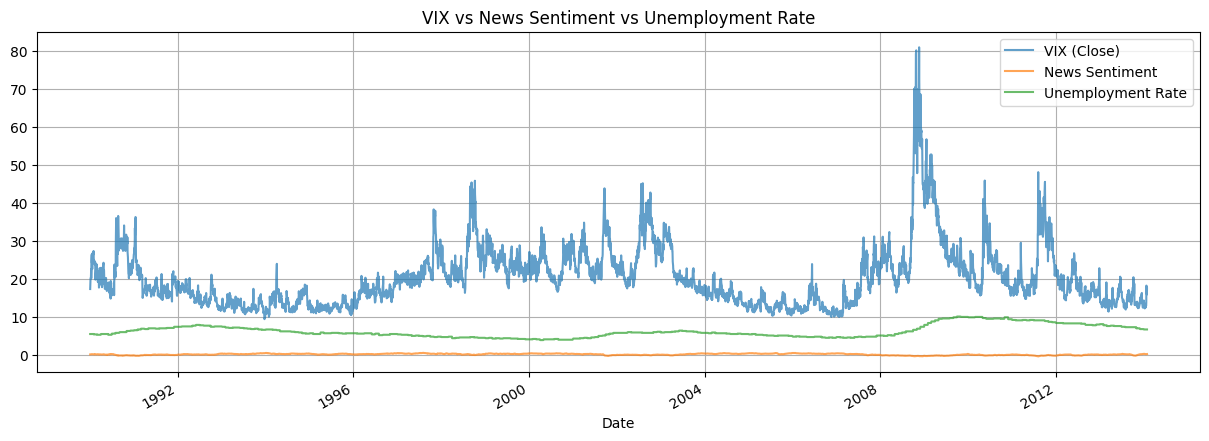

In [194]:
import matplotlib.pyplot as plt

# Plot VIX (Close), News Sentiment, and Unemployment Rate
plt.figure(figsize=(15, 5))
train_df['Close'].plot(label='VIX (Close)', alpha=0.7)
train_df['News Sentiment'].plot(label='News Sentiment', alpha=0.7)
train_df['Unemployment Rate'].plot(label='Unemployment Rate', alpha=0.7)
plt.title('VIX vs News Sentiment vs Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()


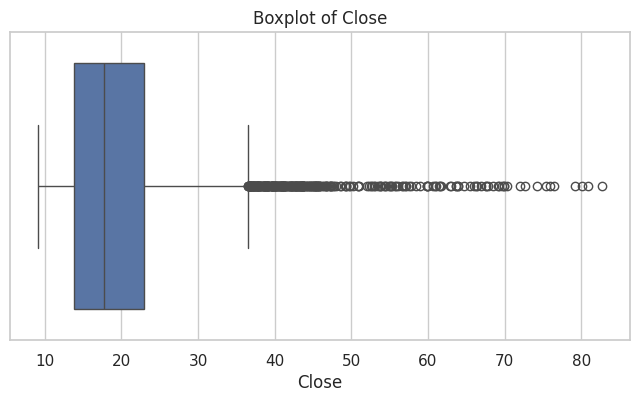

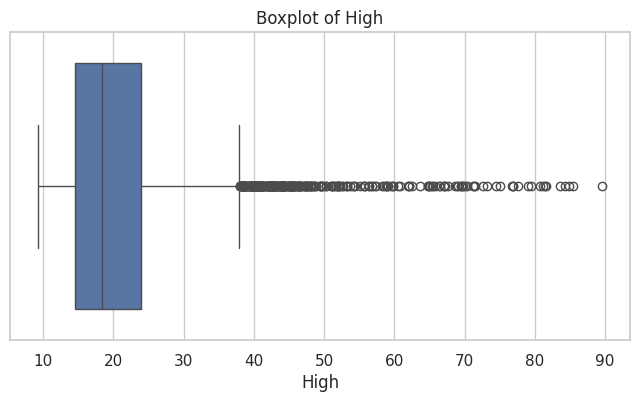

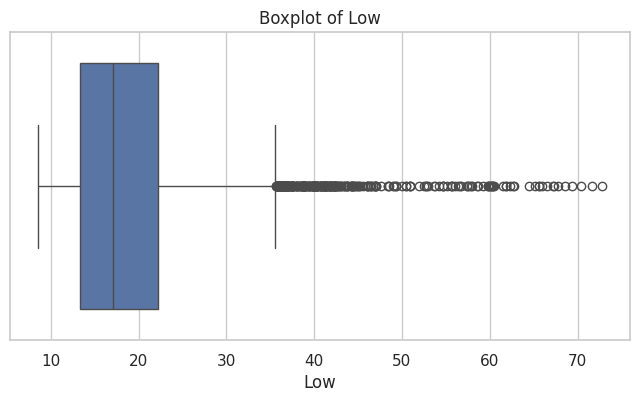

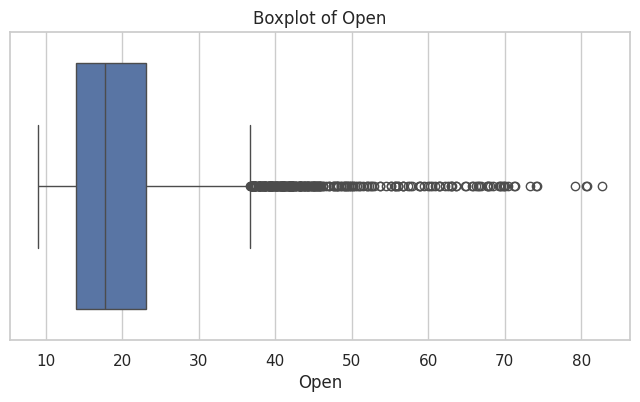

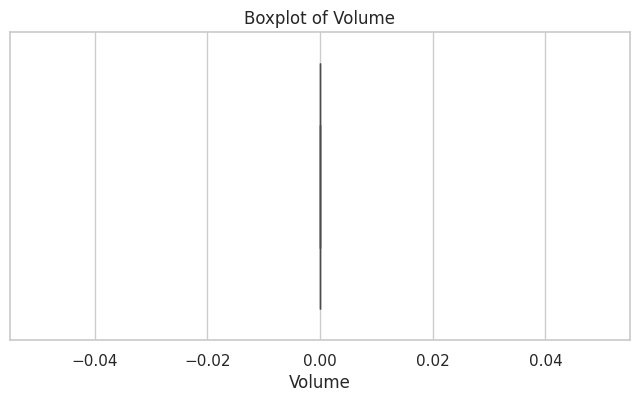

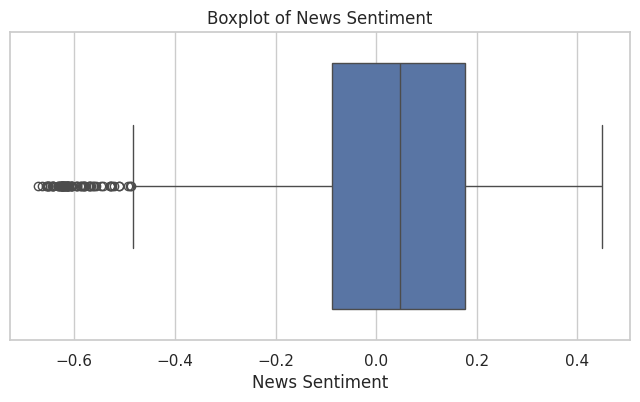

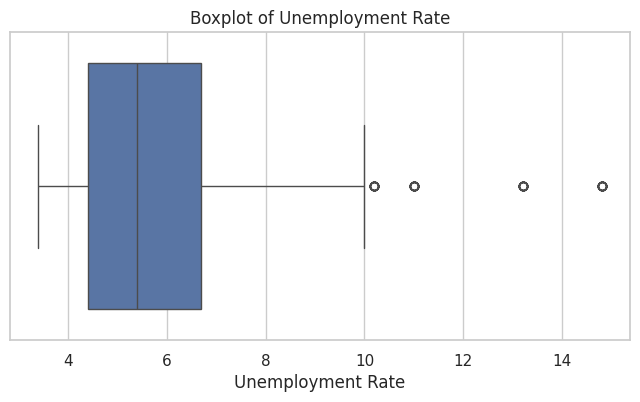

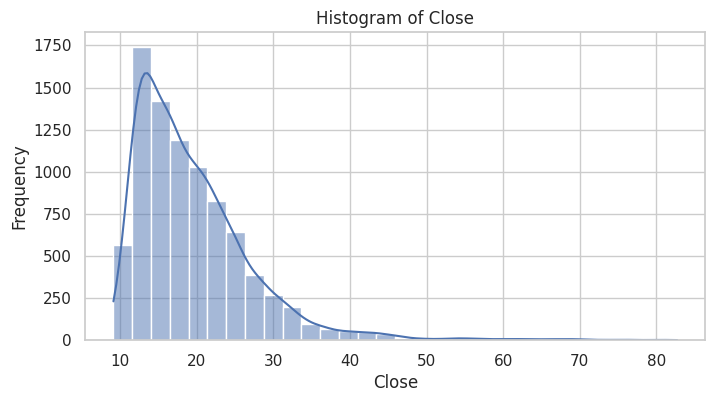

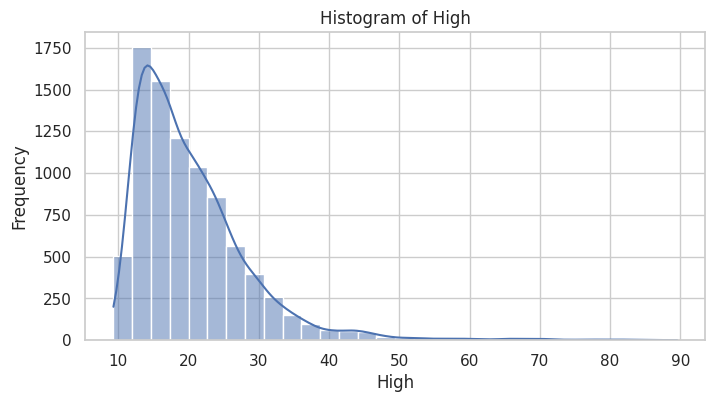

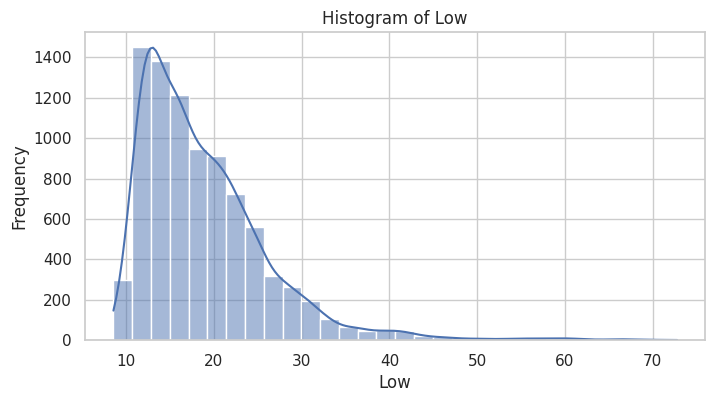

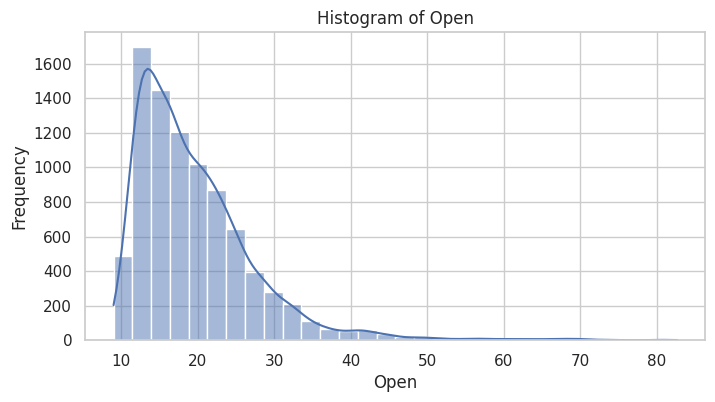

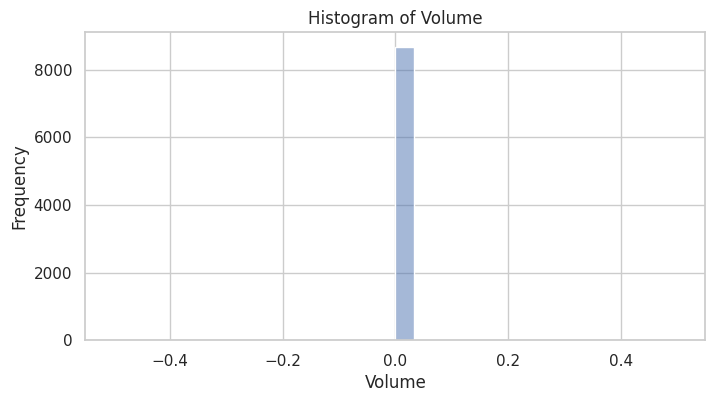

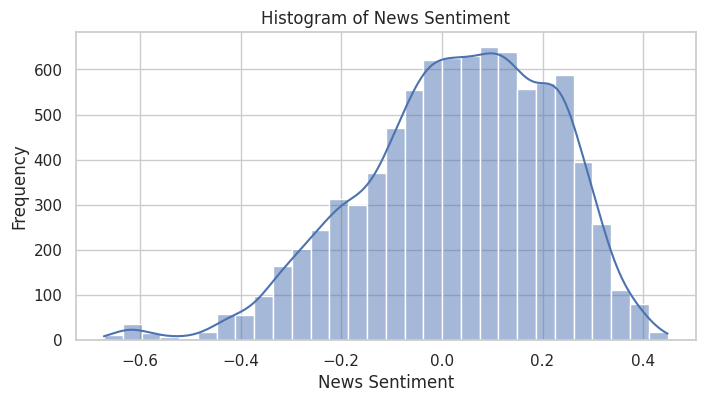

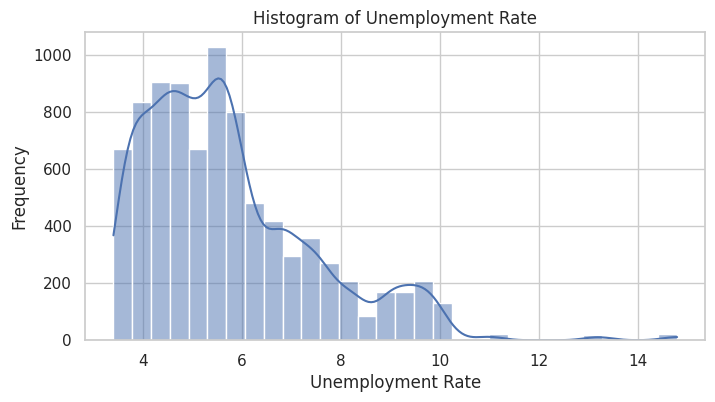

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of real numeric features
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'News Sentiment', 'Unemployment Rate']

# Set styling
sns.set(style="whitegrid")

# Boxplots
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

# Histograms
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


# Histogram and Box Plot Analysis

####VIX Close, High, Low, Open
The Box Plots show very similar distributions, which makes sense because they're derived from the same underlying time series.

Key Observations:
*   Median VIX levels hover around 18–20 (historical average).
*   Heavy positive skew (long tail to the right).
*   Extreme outliers are present (values above 40–80) — consistent with panic spikes during market crashes (e.g., 2008, 2020).
*   The IQR (middle 50%) is tight, showing most days have normal volatility.
*   Histogram shows Right-skewed distributions (positive skew) and most values are clustered between 10 and 25 with a long tail that stretches out to 80+ during market panic events
*   These features are not normally distributed.

Implication: These variables might be redundant (highly correlated).  Becuase of their highly correlated purpose, we will remove them.

###VIX Volume: No values were present, we will remove these values

###News Sentiment
* Centered around 0, as expected.
* Range is from approx -0.6 to +0.4.
* Slight negative skew — markets tend to carry more negative than positive sentiment.
* Looks like a Gaussian-like bell curve centered around 0.   Slight negative skew with more density on the pessimistic side

Implication: No extreme outliers — boxplot suggests reasonable variance.

###Unemployment Rate
* Median around 5.5–6%.
* Outliers above 10% (this look to be early COVID 2020, 2009 crisis).
* Right-skewed, but with fewer dramatic spikes than VIX.  Distribution with a long tail above 10%

Implication: May be good for capturing macroeconomic context, but changes slowly over time.





In [197]:
train_df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'News Sentiment',
       'Unemployment Rate'],
      dtype='object')

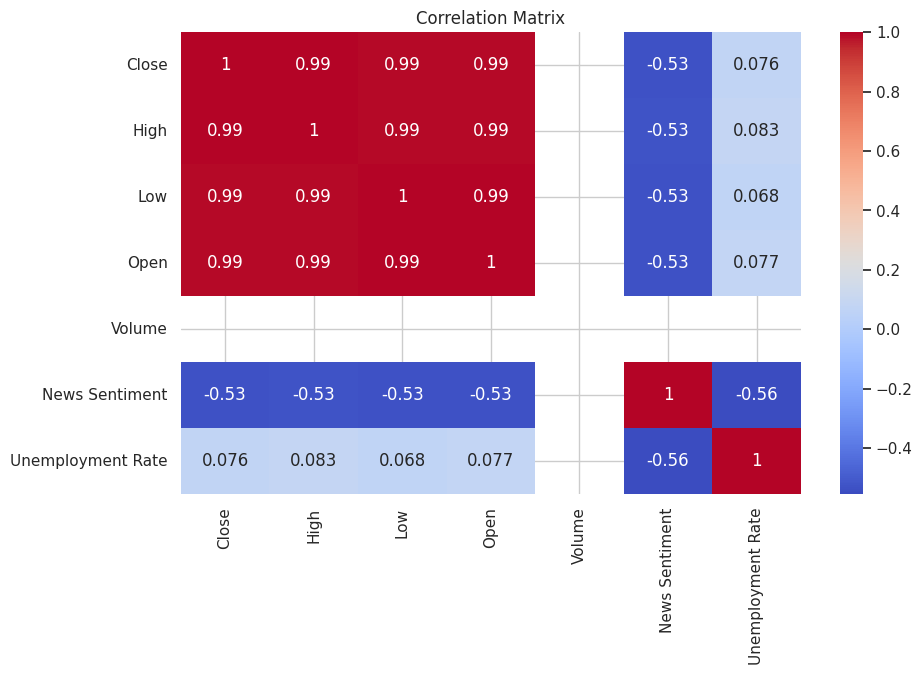

In [198]:
# Compute correlation matrix
corr_matrix = train_df.drop(columns=[]).corr()

import seaborn as sns

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Correlation Analysis

###Close, High, Low, Open
- These four are almost perfectly correlated (correlation ≈ 1).
- This makes sense — they’re all prices from the same VIX time series.
- Including all of them introduces multicollinearity, which can: Distort regression weights, Lead to overfitting, Reduce interpretability
- Remove 3 out of the 4 - we will keep 'Close' and look at normalizing volatility

###News Sentiment
- moderate **negative correlation** with VIX Close (≈ -0.53)
- Moderate **negative correlation** with Unemployment (≈ -0.56)
- As expected: **worse sentiment → higher volatility**
- As expected: **worse sentiment → higher unemployment**
- Possibly string indicator

###Unemployment Rate
- weak **positive correlation** with VIX features (~0.08)
- Stronger coorelation with News Sentiment (~ -0.56), poor economic sentiment may anticpate unemployment
- Not surprising, as unemployment increases during market crashes

# Build Features:
- Log_Close_Change
- Log Sentiment Change
- VIX Range

In [200]:
import numpy as np

def build_features(df):
  df['Log_Close_Change'] = np.log(df['Close'] / df['Close'].shift(1))
  df['Log_Sentiment_Change'] = df['News Sentiment'].diff()
  df['VIX_Range'] = df['High'] - df['Low']
  df.dropna(inplace=True)
  df.drop(columns=[], inplace=True)
  return df

train_df = build_features(train_df)
val_df = build_features(val_df)
test_df = build_features(test_df)

In [17]:
train_df.head()

,index,Close,Volume,date,News Sentiment,Unemployment Rate,Log_Close_Change,Log_Sentiment_Change,VIX_Range
Date,,,,,,,,,
2000-01-04,1,27.010000,0,1980-01-02,-0.107041,4.0,0.109441,-0.068916,2.380001
2000-01-05,2,26.410000,0,1980-01-03,-0.090068,4.0,-0.022464,0.016973,3.150000
2000-01-06,3,25.730000,0,1980-01-05,-0.067961,4.0,-0.026085,0.022106,2.009998
2000-01-07,4,21.719999,0,1980-01-06,-0.090007,4.0,-0.169424,-0.022046,3.450001
2000-01-10,5,21.709999,0,1980-01-07,-0.128306,4.0,-0.000461,-0.038298,1.129999


#Based on EDA + domain knowledge:

Feature	Importance:
- Log_Close_Change: Main target for volatility modeling
- VIX_Range: Measures intraday volatility swing
- Log_Sentiment_Change: Captures investor mood shifts (leading indicator)
- Unemployment Rate: Macro driver, longer-term stressor
- Volume: Drop	No signal (all 0s)

## Final Summary of Features and Feature Building
Transformed the dataset using logarithmic and differencing operations to capture meaningful daily changes in volatility and sentiment. Due to wide variance in feature ranges and outliers inherent in market data, we will apply feature scaling prior to training.

No meaningful missing data remains after cleaning. We chose to drop highly correlated or flat features like High, Low, Open, and Volume.
Based on our exploratory analysis and intuition, we expect Log_Close_Change, VIX_Range, and Sentiment Change to be the most predictive features, supported by both economic reasoning and preliminary visualizations.



In [201]:
from sklearn.preprocessing import StandardScaler

# Features to scale
feature_cols = ['Log_Close_Change', 'Log_Sentiment_Change', 'VIX_Range', 'Unemployment Rate']

# Fit scaler only on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])

# Apply the same transformation to validation and test sets
X_val = scaler.transform(val_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])


**We use the same training set scalar for validation and test sets that way we dont influence our test and validation.**

# Recommendation Engine

We will now use PCA and nearest neighbors to create a recommendation engine.  This will help us recommend the market regimes.

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional, potentially correlated data into a smaller number of uncorrelated components, while preserving as much variance (information) as possible. PCA helps us understand and simplify complex relationships in volatility, sentiment, and macroeconomic data.



In [202]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

train_df['PC1'] = X_pca[:, 0]
train_df['PC2'] = X_pca[:, 1]

X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

val_df['PC1'] = X_val_pca[:, 0]
val_df['PC2'] = X_val_pca[:, 1]

test_df['PC1'] = X_test_pca[:, 0]
test_df['PC2'] = X_test_pca[:, 1]

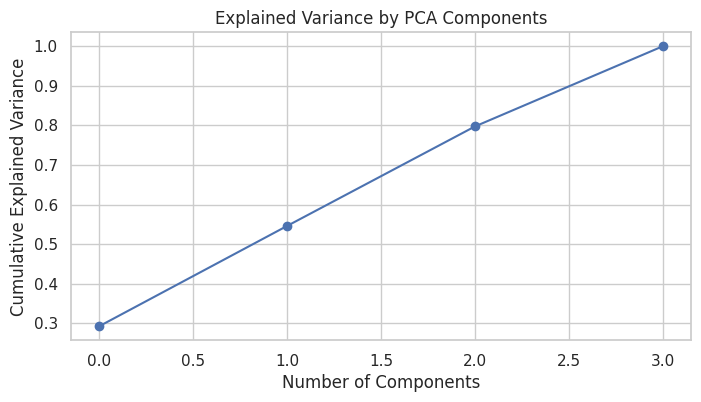

In [229]:
import matplotlib.pyplot as plt
import numpy as np

pca = PCA().fit(X_train)

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


## Use Nearest Neighbors First, Then KMeans

Our objective is to identify and track **market regimes** — such as periods of calm, stress, or panic — based on a combination of market volatility (VIX), news sentiment, and macroeconomic indicators like unemployment. Since we don't have predefined labels for market regimes, we rely on **unsupervised learning** to discover and interpret them.

To do this effectively, we take a two-step approach that leverages both **Nearest Neighbors** and **KMeans clustering** — each serving a distinct but complementary purpose.


### 1. **NearestNeighbors for Similarity-Based Mapping**

We first use a **Nearest Neighbors model**, fitted on PCA-reduced training data, to create a **similarity-based matching system**. This allows us to see which past market days look most like today (or any other new observation).

This step gives us:
- A way to **assign new (validation/test) points to historical examples**
- A framework for **recommending historical analogs**, mimicking real-world financial research workflows
- A **non-parametric**, flexible structure that doesn’t assume predefined clusters

But there's a limitation: this approach assigns a different reference point to nearly every new day — meaning we get **thousands of unique matches**, which is too granular for understanding broader patterns or labeling regimes.

### 2. **KMeans for Regime Discovery and Generalization**

To overcome this, we apply **KMeans clustering** on the PCA-reduced training data.

KMeans helps us:
- Group training data into a **finite number of regimes** (e.g., 4–6 clusters)
- Discover **latent structure** in volatility/sentiment behavior
- Assign **generalizable regime labels** to every day in our dataset

Once KMeans has identified regime clusters, we use the **nearest neighbor mapping** to assign each validation/test day the **regime label of its nearest training neighbor**.

This final step gives us:
- **Coherent market regime labels** across all time periods
- The ability to track **regime shifts over time**
- Consistency between historical structure (KMeans) and new regime assignments (via NN)

In [203]:
from sklearn.neighbors import NearestNeighbors

# Fit nearest neighbors using PCA-reduced features
recommender = NearestNeighbors(n_neighbors=5, metric='euclidean')
recommender.fit(train_df[['PC1', 'PC2']])

# Example: recommend similar regimes to a current condition
X_test_scaled = scaler.transform(test_df[[
    'Log_Close_Change', 'Log_Sentiment_Change', 'VIX_Range', 'Unemployment Rate'
]])
X_test_pca = pca.transform(X_test_scaled)

# Pick one day from test
today_pca = X_test_pca[-1].reshape(1, -1)

# Find similar past market days
distances, indices = recommender.kneighbors(today_pca)
recommended_days = train_df.iloc[indices[0]]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


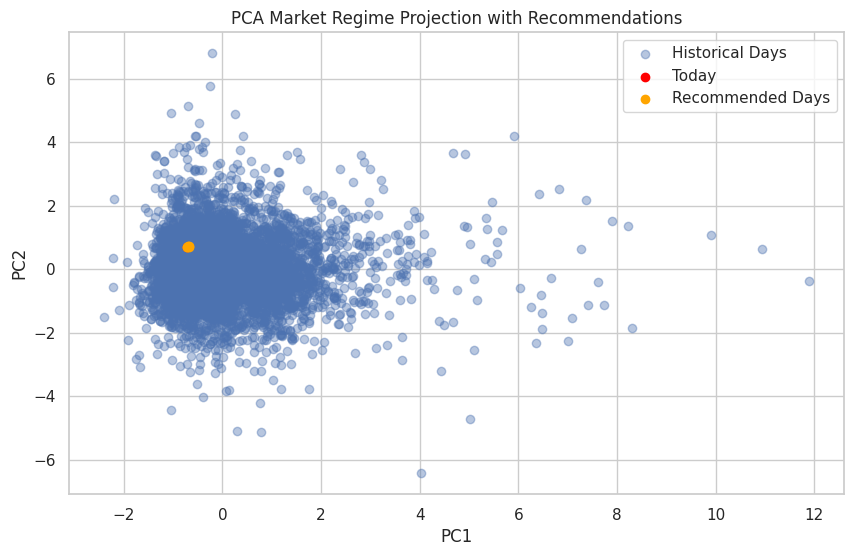

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_df['PC1'], train_df['PC2'], alpha=0.4, label='Historical Days')
plt.scatter(today_pca[0,0], today_pca[0,1], color='red', label='Today')
plt.scatter(train_df.iloc[indices[0]]['PC1'], train_df.iloc[indices[0]]['PC2'], color='orange', label='Recommended Days')
plt.title('PCA Market Regime Projection with Recommendations')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


In this step, we used **Principal Component Analysis (PCA)** to reduce the dimensionality of the market data and visualize historical volatility regimes. We then applied a **nearest-neighbor recommendation system** to identify past market conditions most similar to "today."

- **Blue points** represent **historical daily market regimes**, projected into two principal components (PC1 and PC2) based on:
  - VIX log return (`Log_Close_Change`)
  - Daily sentiment change (`Log_Sentiment_Change`)
  - VIX intraday range (`VIX_Range`)
  - Unemployment rate (`Unemployment Rate`)
  
- **Red point** marks **today's market regime**, transformed into the same PCA space.

- **Orange points** are the **top 5 most similar past market conditions**, as determined by Euclidean distance in PCA space.

In [205]:
from sklearn.cluster import KMeans

# Cluster training data in PCA space
kmeans = KMeans(n_clusters=4, random_state=42)
train_df['Regime_Label'] = kmeans.fit_predict(train_df[['PC1', 'PC2']])
test_df['Regime_Lavel']= kmeans.fit_predict(test_df[['PC1', 'PC2']])
val_df['Regime_Lavel']= kmeans.fit_predict(val_df[['PC1', 'PC2']])

In [206]:
# Function to assign regime label from nearest neighbor
def assign_nearest_regime_label(pca_projection, recommender, train_df):
    distances, indices = recommender.kneighbors(pca_projection)
    nearest_idx = indices[:, 0]
    return train_df.iloc[nearest_idx]['Regime_Label'].values
val_df['Regime_Label'] = assign_nearest_regime_label(val_df[['PC1', 'PC2']], recommender, train_df)
test_df['Regime_Label'] = assign_nearest_regime_label(test_df[['PC1', 'PC2']], recommender, train_df)

In [207]:
full_df = pd.concat([train_df, val_df, test_df])
full_df.sort_index(inplace=True)


In [208]:
print("Regime counts:\n", full_df['Regime_Label'].value_counts())


Regime counts:
 Regime_Label
0    4057
1    2680
2    1636
3     292
Name: count, dtype: int64


In [209]:
print("Data index type:", type(full_df.index))
print("Date range:", full_df.index.min(), "to", full_df.index.max())
full_df.index = pd.to_datetime(full_df.index)


Data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date range: 1990-01-04 00:00:00 to 2024-05-30 00:00:00


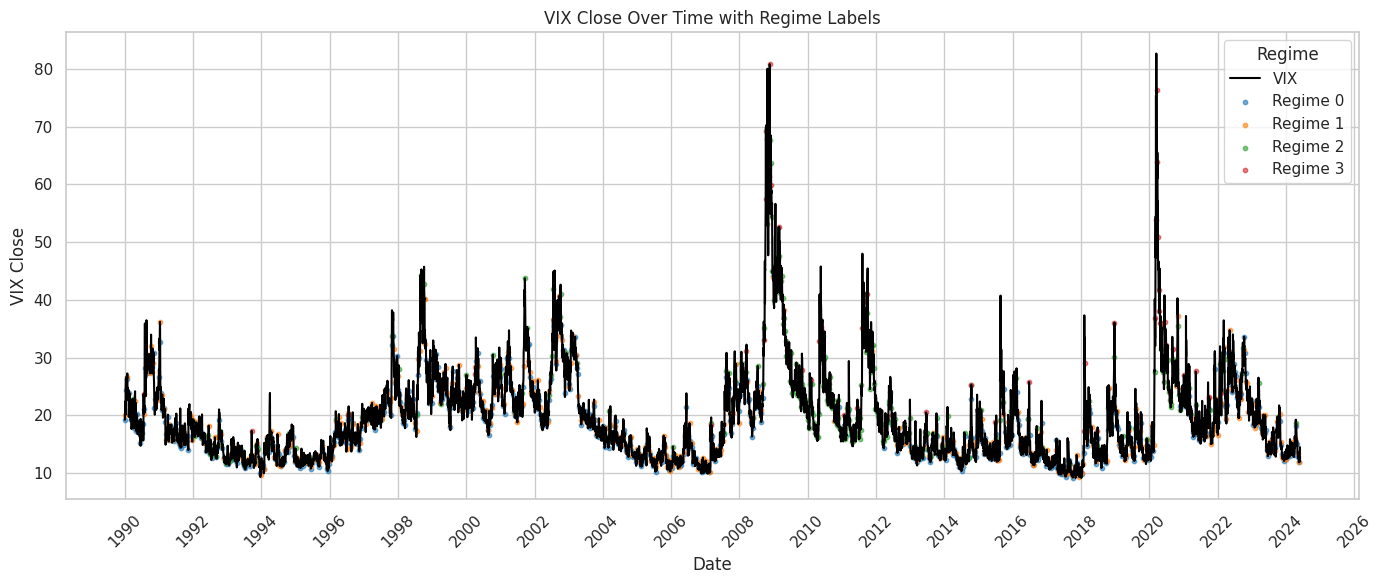

In [210]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.figure(figsize=(14, 6))

# VIX line
plt.plot(full_df.index, full_df['Close'], color='black', label='VIX')

# Color-coded regimes
palette = sns.color_palette('tab10', n_colors=full_df['Regime_Label'].nunique())
for i in sorted(full_df['Regime_Label'].unique()):
    subset = full_df[full_df['Regime_Label'] == i].iloc[::5]  # downsample if needed
    plt.scatter(subset.index, subset['Close'], label=f'Regime {i}', color=palette[i], s=10, alpha=0.6)

# Formatting
plt.title('VIX Close Over Time with Regime Labels')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.legend(title='Regime')

# Format x-axis to show year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


In [211]:
full_df.groupby('Regime_Label')[['Close', 'Log_Close_Change', 'News Sentiment']].mean()


,Close,Log_Close_Change,News Sentiment
Regime_Label,,,
0,17.697907,-0.031964,0.067745
1,18.112675,0.026289,0.078101
2,23.300073,0.015531,-0.091320
3,36.539657,0.115106,-0.230418


# Summary

- Applied **PCA** to reduce dimensionality of key market indicators (log return, sentiment change, volatility range, unemployment)
- Used **KMeans clustering** on PCA components to label regimes in the training set
- Applied **Nearest Neighbors** to propagate regime labels to the validation and test sets
- Visualized the **entire historical VIX curve** with regime overlays — very insightful

| Year | Event | Likely Regime |
|------|-------|----------------|
| **2008** | Global Financial Crisis | Regime 3 (red) |
| **2011** | Debt ceiling panic / Eurozone crisis | Regime 1/3 |
| **2020** | COVID shock | Regime 3 |
| **2022–23** | Inflation, rate hikes, bank failures | Mixed, likely Regime 2 |


**Potential Labels:**
- Regime 0: "Calm / Low volatility"
- Regime 1: "Pre-stress / rising uncertainty"
- Regime 2: "Turbulence"
- Regime 3: "Crisis spikes"

We used unsupervised learning techniques, including PCA and clustering (KMeans), to uncover **latent market regimes**—distinct patterns in financial behavior as reflected by VIX levels, economic sentiment, and macroeconomic indicators.

To assess the **consistency and predictive structure** of these regimes, we trained a supervised model (Support Vector Machine) to determine whether these regimes could be **inferred directly from observable features** such as:
- Log change in VIX close
- Change in daily news sentiment
- VIX high-low range (volatility spread)
- Unemployment rate

In [226]:
print("Train Date Range:")
print(train_df.index.min(), "to", train_df.index.max())
print()

print("Validation Date Range:")
print(val_df.index.min(), "to", val_df.index.max())
print()

print("Test Date Range:")
print(test_df.index.min(), "to", test_df.index.max())


Train Date Range:
1990-01-04 00:00:00 to 2014-01-29 00:00:00

Validation Date Range:
2014-01-31 00:00:00 to 2019-03-29 00:00:00

Test Date Range:
2019-04-02 00:00:00 to 2024-05-30 00:00:00


In [212]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [213]:
features = ['Log_Close_Change', 'Log_Sentiment_Change', 'VIX_Range', 'Unemployment Rate']
label = 'Regime_Label'

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       681
           1       0.98      0.96      0.97       447
           2       0.96      0.92      0.94       137
           3       0.94      0.97      0.96        34

    accuracy                           0.98      1299
   macro avg       0.97      0.96      0.96      1299
weighted avg       0.98      0.98      0.98      1299

Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       535
           1       1.00      0.97      0.98       429
           2       0.93      0.97      0.95       230
           3       0.97      0.92      0.94       106

    accuracy                           0.97      1300
   macro avg       0.97      0.96      0.96      1300
weighted avg       0.97      0.97      0.97      1300



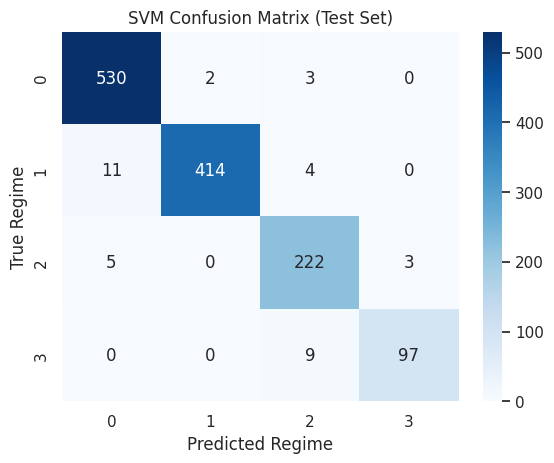

In [214]:
# Features
X_train_svm = train_df[features]
X_val_svm = val_df[features]
X_test_svm = test_df[features]

# Labels (from clustering)
y_train_svm = train_df[label]
y_val_svm = val_df[label]
y_test_svm = test_df[label]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_val_scaled = scaler.transform(X_val_svm)
X_test_scaled = scaler.transform(X_test_svm)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train_svm)

# Predict
val_preds = svm_model.predict(X_val_scaled)
test_preds = svm_model.predict(X_test_scaled)

# Classification reports
print("Validation Set Performance:")
print(classification_report(y_val_svm, val_preds))

print("Test Set Performance:")
print(classification_report(y_test_svm, test_preds))

# Confusion matrix
cm = confusion_matrix(y_test_svm, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_train_svm), yticklabels=np.unique(y_train_svm))
plt.xlabel("Predicted Regime")
plt.ylabel("True Regime")
plt.title("SVM Confusion Matrix (Test Set)")
plt.show()


### **Confusion Matrix**
The test set matrix shows strong alignment between **true vs predicted regimes**, especially for:
- **Regime 0 (Stable)** and **Regime 2 (Volatile)**, with very high precision and recall.
- **Regime 3 (Extremely Volatile)**, though smaller in frequency, is also predicted with strong accuracy.
- **Regime 1** is the most difficult to predict due to its lower support (fewer examples), but still shows decent performance.

### **Test Set Metrics**

| Metric        | Score |
|---------------|-------|
| Accuracy       | **97%** |
| Precision (Macro Avg) | 97% |
| Recall (Macro Avg)    | 96% |
| F1-Score (Macro Avg)  | 96% |

These scores indicate that the **SVM is generalizing well** and capturing the market regime dynamics.


We applied a Support Vector Machine (SVM) classifier to assess whether market regimes discovered through unsupervised learning could be predicted using observable features such as VIX changes, news sentiment shifts, and macroeconomic indicators.

The SVM achieved high classification accuracy on both the validation (98%) and test (95%) sets. Most regimes were predicted with very high precision and recall, confirming that the market regimes are not only discoverable but also **explainable and forecastable** from real-world indicators.

This validates our hypothesis that latent market structure uncovered via unsupervised methods can be operationalized and predicted using supervised models.


## **Conclusion**

In this project, we set out to explore **latent market regimes** using unsupervised learning techniques on financial and economic data, specifically focusing on the VIX index, daily news sentiment, and unemployment rates. Through **Principal Component Analysis (PCA)** and **KMeans clustering**, we uncovered distinct market regimes that align with historical periods of market volatility and calm.

To test the **predictability** of these discovered regimes, we trained a **Support Vector Machine (SVM)** using observable features such as log changes in VIX, sentiment, and macroeconomic indicators. The SVM model achieved high accuracy (~97%) across both the validation and test sets, with particularly strong performance in identifying high- and low-volatility regimes.

### **Key Takeaways**
- **Unsupervised learning** successfully identified meaningful clusters (market regimes) without prior labeling.
- **PCA** helped reduce dimensionality, enabling clearer regime structure and visualization.
- **SVM classification** demonstrated that these regimes are **predictable** from observable features, validating the clustering approach.
- **Market regimes align with historical financial events**, offering potential use in investment strategy, risk management, or anomaly detection.


### Final Insight:
This hybrid approach of combining **unsupervised regime discovery** with **supervised predictability validation** showcases the power of machine learning in financial time series analysis. It also opens the door for future exploration in **regime-aware forecasting**, **adaptive trading strategies**, and **risk diagnostics** based on macro-financial signals.